In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans
import random
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cpu")

In [2]:
class MLP(nn.Module):
    def __init__(self, n_features, n_clusters):
        super(MLP, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(n_features, n_clusters, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(n_clusters),
        )

    def forward(self, x, temperature=1):
        x = self.model(x)
        x = F.softmax(x/temperature, dim=1)
        return x

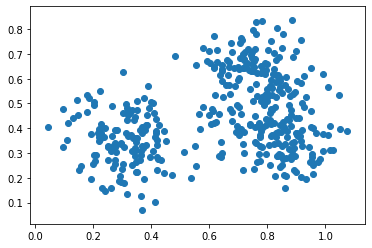

In [3]:
n_samples = 400
n_clusters = 3
n_features = 2
cluster_std = 0.1
mlp = MLP(n_features, n_clusters)
data, labels = make_blobs(n_samples=n_samples, centers=n_clusters, n_features=n_features, cluster_std=cluster_std, center_box=(0, 1))
plt.scatter(data[:, 0], data[:,1])

data = torch.Tensor(data)
labels = torch.Tensor(labels)
dataset = TensorDataset(data, labels)

In [4]:
def soft_silhouette(X, soft_clustering, requires_distance_grad=False):
    # No grads at distances
    if requires_distance_grad: X = X.detach()
    distances = torch.cdist(X, X, p=2)
    alphas = torch.matmul(distances, soft_clustering)
    n_data, n_clusters = alphas.shape
    betas = torch.empty(alphas.shape)
    
    for i in range(n_data):
        for j in range(n_clusters):
            betas[i][j] = min([alphas[i][x] for x in range(alphas.shape[1]) if x!=j])
    
    # Calculate soft silhouette
    sc = torch.div(torch.sub(betas, alphas), torch.max(alphas, betas))
    s = torch.mean(torch.sum(torch.mul(soft_clustering, sc), dim=1))

    return s

In [5]:
learning_rate = 0.1
batch_size = 100
epochs = 50

optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)
dataloader = DataLoader(dataset, batch_size=batch_size)
mlp.train()

for epoch in range(epochs):
    for batch_index, (data, labels) in enumerate(dataloader):
        soft_clustering = mlp(data)
        loss = 1 - soft_silhouette(data, soft_clustering)
        #loss = torch.log(1 - soft_silhouette(data, soft_clustering))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: {:d} Loss {:.4f}".format(epoch, loss))

Epoch: 0 Loss 0.8691
Epoch: 1 Loss 0.8387
Epoch: 2 Loss 0.6763
Epoch: 3 Loss 0.6300
Epoch: 4 Loss 0.6016
Epoch: 5 Loss 0.5891
Epoch: 6 Loss 0.5752
Epoch: 7 Loss 0.5648
Epoch: 8 Loss 0.5590
Epoch: 9 Loss 0.5546
Epoch: 10 Loss 0.5514
Epoch: 11 Loss 0.5491
Epoch: 12 Loss 0.5470
Epoch: 13 Loss 0.5452
Epoch: 14 Loss 0.5438
Epoch: 15 Loss 0.5425
Epoch: 16 Loss 0.5414
Epoch: 17 Loss 0.5404
Epoch: 18 Loss 0.5395
Epoch: 19 Loss 0.5387
Epoch: 20 Loss 0.5379
Epoch: 21 Loss 0.5372
Epoch: 22 Loss 0.5365
Epoch: 23 Loss 0.5358
Epoch: 24 Loss 0.5353
Epoch: 25 Loss 0.5347
Epoch: 26 Loss 0.5342
Epoch: 27 Loss 0.5337
Epoch: 28 Loss 0.5332
Epoch: 29 Loss 0.5327
Epoch: 30 Loss 0.5323
Epoch: 31 Loss 0.5319
Epoch: 32 Loss 0.5314
Epoch: 33 Loss 0.5311
Epoch: 34 Loss 0.5307
Epoch: 35 Loss 0.5303
Epoch: 36 Loss 0.5300
Epoch: 37 Loss 0.5297
Epoch: 38 Loss 0.5293
Epoch: 39 Loss 0.5290
Epoch: 40 Loss 0.5287
Epoch: 41 Loss 0.5284
Epoch: 42 Loss 0.5282
Epoch: 43 Loss 0.5279
Epoch: 44 Loss 0.5276
Epoch: 45 Loss 0.527

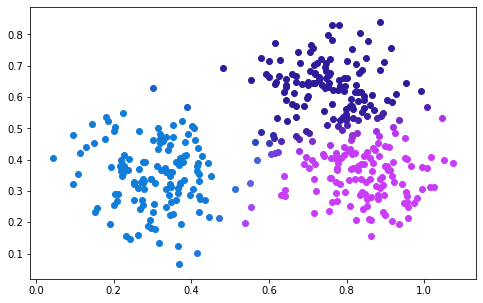

In [6]:
colors = list()
for _ in range(n_clusters):
    r = random.uniform(0, 1)
    g = random.uniform(0, 1)
    b = random.uniform(0, 1)
    colors.append((r, g, b))

mlp.eval()
dataloader = DataLoader(dataset, batch_size=1)
clustering = list()
real_labels = list()
plt.figure(figsize=(8, 5))
for batch_index, (data, labels) in enumerate(dataloader):
    soft_clustering = mlp(data).detach().numpy()
    clustering.append(soft_clustering)
    real_labels.append(labels.detach().numpy())
    
    color = (0, 0, 0)
    for i in range(n_clusters):
        membership_i = tuple([pixel * soft_clustering[0][i] for pixel in colors[i]])
        color = tuple([sum(x) for x in zip(color, membership_i)])
    
    plt.scatter(data[:, 0], data[:, 1], color=color)
    #plt.scatter(data[:, 0], data[:, 1], c=colormap[soft_clustering])
plt.show()

In [12]:
mlp(data, temperature=0.1)

tensor([[9.7921e-33, 1.8518e-31, 1.0000e+00]], grad_fn=<SoftmaxBackward>)